# Imports

In [1]:
import time
import os
import sys
import pickle as pkl

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from IPython.display import clear_output

import vcf

import src.simulate

In [2]:
%load_ext autoreload
%autoreload 2

# Simulated

In [11]:
p0, p1, p2 = 0.33, 0.33, 0.34
pop_names = ['Africa', 'Europe', 'America', 'Asia', 'Oceania']

haps_dict = src.simulate.simulate_naive(
    p0, p1, p2, pop_names, num_haps=6000, hap_len=6000
)

H = np.zeros((0, 6000), dtype=np.int8)
for pop in haps_dict.keys():
    H = np.vstack([H, haps_dict[pop]])

In [16]:
pca = PCA(n_components=2)
H_reduced = pca.fit_transform(H)

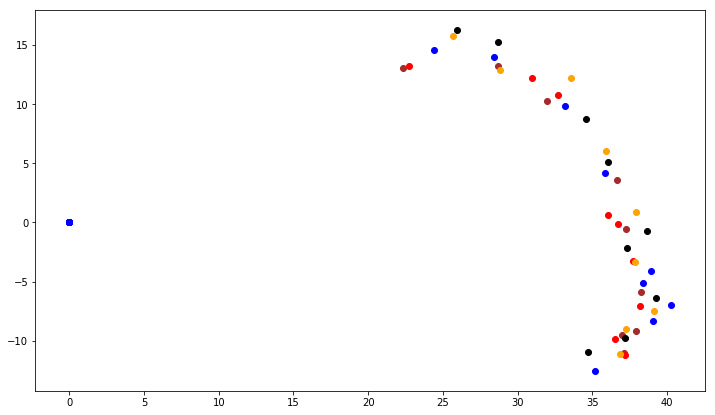

In [19]:
f, ax = plt.subplots(figsize=(12, 7))

clr_map = ['brown', 'black', 'red', 'orange', 'blue']
for c_num, i in enumerate(range(0, 30000, 6000)):
    x_plt = H_reduced[i:(i+6000), 0]
    y_plt = H_reduced[i:(i+6000), 1]
    ax.scatter(
        x_plt, y_plt, c=clr_map[c_num]
    )
    
plt.show()

# Real data (chromosome 22)

In [4]:

path = '/home/cole/Desktop/1000G/PHASE1/'

filename = [s for s in os.listdir(path) if s[-3:] != '.gz']
assert len(filename) == 1
filename = filename[0]

vcf_reader = vcf.Reader(open(path + filename, 'r'))

for record in vcf_reader:
    atts = [s for s in dir(record) if s[:2] != '__']
    break

In [5]:
print(atts)
print('='*60)

call = record.samples[0]
atts_call = [s for s in dir(call) if s[:2] != '__']

print(atts_call)
print('='*60)

hg_names = dict()
for i, c in enumerate(record.samples):
    assert c.sample not in hg_names.keys()
    hg_names[c.sample] = i

print('CALL:', call.gt_bases, call.gt_nums, call.phased, call.sample)
print('REC:', record.ID, record.REF, record.alleles, record.call_rate)

['ALT', 'CHROM', 'FILTER', 'FORMAT', 'ID', 'INFO', 'POS', 'QUAL', 'REF', '_compute_coordinates_for_indel', '_compute_coordinates_for_none_alt', '_compute_coordinates_for_snp', '_compute_coordinates_for_sv', '_sample_indexes', '_set_start_and_end', 'aaf', 'add_filter', 'add_format', 'add_info', 'affected_end', 'affected_start', 'alleles', 'call_rate', 'end', 'genotype', 'get_hets', 'get_hom_alts', 'get_hom_refs', 'get_unknowns', 'heterozygosity', 'is_deletion', 'is_indel', 'is_monomorphic', 'is_snp', 'is_sv', 'is_sv_precise', 'is_transition', 'nucl_diversity', 'num_called', 'num_het', 'num_hom_alt', 'num_hom_ref', 'num_unknown', 'samples', 'start', 'sv_end', 'var_subtype', 'var_type']
['called', 'data', 'gt_alleles', 'gt_bases', 'gt_nums', 'gt_phase_char', 'gt_type', 'is_het', 'is_variant', 'phased', 'ploidity', 'sample', 'site']
CALL: T|T 0|0 True HG00096
REC: rs149201999 T ['T', C] 1.0


In [71]:
record.samples, record.ID
col_names = []
path = '/home/cole/Desktop/1000G/PHASE1/'

filename = [s for s in os.listdir(path) if s[-3:] != '.gz']
assert len(filename) == 1
filename = filename[0]

vcf_reader = vcf.Reader(open(path + filename, 'r'))
n = len(hg_names)

H = np.zeros((2 * n, 0), dtype=np.int8)

for record_number, record in enumerate(vcf_reader):
    if (record.call_rate != 1.0) or (not record.is_snp) or (record.num_called != n):
        continue
     
    new_col = np.zeros((2*n, 1))
    for call in record.samples:
        h_row = 2 * hg_names[call.sample]
        assert call.phased
        
        new_col[h_row, 0] = int(call.gt_nums[0])
        new_col[h_row+1, 0] = int(call.gt_nums[-1])
    
    H = np.hstack([H, new_col])
    col_names.append(record.ID)
    
    if (record_number % 100) == 0:
        np.savetxt('data/H.txt', H)
        clear_output()
        print('r_num={0}; nc={1}'.format(record_number, H.shape[1]))
        
        f = open('data/variant_names.p', 'wb')
        pkl.dump(col_names, f)
        f.close()
        
    if H.shape[1] == 15000:
        np.savetxt('data/H.txt', H)
    
clear_output()
print('finished with %d columns' % H.shape[1])
       
    

r_num=17300; nc=16383


KeyboardInterrupt: 

In [6]:
col_names = []
path = '/home/cole/Desktop/1000G/PHASE1/'

filename = [s for s in os.listdir(path) if s[-3:] != '.gz']
assert len(filename) == 1
filename = filename[0]

vcf_reader = vcf.Reader(open(path + filename, 'r'))
n = len(hg_names)

Hs = 0
for record_number, record in enumerate(vcf_reader):
    if (record.call_rate != 1.0) or (not record.is_snp) or (record.num_called != n):
        continue
    
    col_names.append(record.ID)
    Hs += 1
    
    if Hs == 16285:
        break
    
f = open('data/variant_names.p', 'wb')
pkl.dump(col_names, f)
f.close()
        
    